# Digits Dataset Template
Optuna example that optimizes a neural network classifier configuration for the digit dataset using Keras.

In [1]:
import optuna

Import more useful libraries

In [2]:
import pickle
import numpy as np

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for neural networks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# machine learning basics
from sklearn.datasets import load_digits
# train_test_split was moved from cross_validation to model_selection in 0.18
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

In [28]:
BATCHSIZE = 100
# number of epochs
EPOCHS = 10

# needed to save best model so far
global best_accuracy_so_far

## The objective function for optuna to optimize the hyperparameters

In [29]:
def objective(trial):
    global best_accuracy_so_far

    # Clear clutter from previous Keras session graphs.
    clear_session()

    digits = load_digits()

    # get features X and labels y
    X = digits['data']
    y = digits['target']

    # split dataset into training and validation datasets
    X_train, X_val, y_train, y_val = train_test_split(X, y)

    scaler = StandardScaler()
    # Fit only to the training data
    scaler.fit(X_train)
    # save fitted scaler, because you need it later for the test dataset
    pickle.dump(scaler, open("scaler.p", "wb"))

    # Now apply the transformations to the data:
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)

    # create neural network
    model = Sequential()

    model.add(Input(shape=64))
    model.add(Dense(16, kernel_initializer='uniform', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(units=trial.suggest_int("units", 8, 24, step=4), kernel_initializer='uniform',
                    activation=trial.suggest_categorical("activation", ["relu", "linear"])))
    # Adding dropout to prevent overfitting
    model.add(Dropout(rate=trial.suggest_float("rate", 0.0, 0.1, step=0.1)))
    model.add(Dense(10, kernel_initializer='uniform', activation='sigmoid'))

    # We compile our model with a sampled learning rate.
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=Adam(learning_rate=learning_rate),
        metrics=["accuracy"],
    )

    # train neural network
    model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        shuffle=True,
        batch_size=BATCHSIZE,
        epochs=EPOCHS,
        verbose=False,
    )

    # Evaluate the model accuracy on the validation set.
    score = model.evaluate(X_val, y_val, verbose=0)

    # save best model so far to be able to use the best model later to predict with test data
    if score[1] >= best_accuracy_so_far:
        tf.keras.models.save_model(model, '{0}.mdl'.format(trial.number))
        best_accuracy_so_far = score[1]

    # return accuracy
    return score[1]

# Main Function

Use optuna to do hyperparameter optimization to find optimal neural network architecture

In [30]:
best_accuracy_so_far = -100
study = optuna.create_study(direction="maximize")
# be cautious with the number of trials: Do not use a number larger than 50
# this call starts the hyperparameter optimization process: the above define function "objective" is called with
# n_trials different hyperparameter combinations
study.optimize(objective, n_trials=5, timeout=600)

[I 2022-09-27 22:55:15,469] A new study created in memory with name: no-name-b9d48688-2ffd-4008-91d8-f7586e88d60d


INFO:tensorflow:Assets written to: 0.mdl\assets


[I 2022-09-27 22:55:17,441] Trial 0 finished with value: 0.46666666865348816 and parameters: {'units': 12, 'activation': 'linear', 'rate': 0.1, 'learning_rate': 0.00033183388518097265}. Best is trial 0 with value: 0.46666666865348816.
[I 2022-09-27 22:55:18,367] Trial 1 finished with value: 0.2755555510520935 and parameters: {'units': 16, 'activation': 'linear', 'rate': 0.0, 'learning_rate': 4.0203961742275026e-05}. Best is trial 0 with value: 0.46666666865348816.


INFO:tensorflow:Assets written to: 2.mdl\assets


[I 2022-09-27 22:55:19,972] Trial 2 finished with value: 0.9422222375869751 and parameters: {'units': 24, 'activation': 'linear', 'rate': 0.1, 'learning_rate': 0.005032934955314838}. Best is trial 2 with value: 0.9422222375869751.
[I 2022-09-27 22:55:20,996] Trial 3 finished with value: 0.3199999928474426 and parameters: {'units': 20, 'activation': 'relu', 'rate': 0.1, 'learning_rate': 5.823106291071733e-05}. Best is trial 2 with value: 0.9422222375869751.
[I 2022-09-27 22:55:21,985] Trial 4 finished with value: 0.5222222208976746 and parameters: {'units': 24, 'activation': 'linear', 'rate': 0.1, 'learning_rate': 0.00012083820134011802}. Best is trial 2 with value: 0.9422222375869751.


Analyse the best model and use it to predict accuracy on test data

In [31]:
print("Best trial:")
trial = study.best_trial
print(trial)

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
FrozenTrial(number=2, values=[0.9422222375869751], datetime_start=datetime.datetime(2022, 9, 27, 22, 55, 18, 368136), datetime_complete=datetime.datetime(2022, 9, 27, 22, 55, 19, 972131), params={'units': 24, 'activation': 'linear', 'rate': 0.1, 'learning_rate': 0.005032934955314838}, distributions={'units': IntDistribution(high=24, log=False, low=8, step=4), 'activation': CategoricalDistribution(choices=('relu', 'linear')), 'rate': FloatDistribution(high=0.1, log=False, low=0.0, step=0.1), 'learning_rate': FloatDistribution(high=0.1, log=True, low=1e-05, step=None)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=2, state=TrialState.COMPLETE, value=None)
  Value: 0.9422222375869751
  Params: 
    units: 24
    activation: linear
    rate: 0.1
    learning_rate: 0.005032934955314838


Load the best model. This model was saved in the function "objective".

In [32]:
best_model = tf.keras.models.load_model('{0}.mdl'.format(trial.number))

### Return performance of final model on new data (test data)
TODO: only load test data here, that you get a few days before the deadline.

In [33]:
digits = load_digits()

X_test = digits['data']
y_test = digits['target']

scaler = pickle.load(open("scaler.p", "rb"))
# important: preprocessing of test dataset has to be the same as for the training dataset
X_test = scaler.transform(X_test)

Predicting the Test set results

In [34]:
y_pred = best_model.predict(X_test)
print(y_pred)
# create labels out of predictions
y_pred_labels = np.argmax(y_pred, axis=1)

57/57 [==============================] - 0s 679us/step
[[0.99999833 0.0055533  0.00418545 ... 0.00194408 0.19929063 0.99875104]
 [0.00419465 0.9999859  0.64393127 ... 0.13658027 0.99594706 0.14782026]
 [0.00133157 0.9945251  0.99998873 ... 0.01164467 0.9998611  0.05846959]
 ...
 [0.02676658 0.9997624  0.8972547  ... 0.01197907 0.99870217 0.29906562]
 [0.9933501  0.599191   0.01041896 ... 0.01027927 0.96585983 0.9997168 ]
 [0.18437509 0.9551303  0.8996283  ... 0.01389111 0.99546844 0.8004999 ]]


Making the Confusion Matrix

In [35]:
cm = confusion_matrix(y_test, y_pred_labels)

print("Our accuracy is {}%".format(((cm[0][0] + cm[1][1]) / cm.sum()) * 100))

Our accuracy is 19.421257651641625%


Plot heatmap

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       178
           1       0.92      0.96      0.94       182
           2       0.99      0.99      0.99       177
           3       0.96      0.98      0.97       183
           4       0.98      0.97      0.98       181
           5       0.98      0.97      0.98       182
           6       0.99      0.99      0.99       181
           7       0.98      0.99      0.99       179
           8       0.94      0.87      0.90       174
           9       0.96      0.95      0.95       180

    accuracy                           0.97      1797
   macro avg       0.97      0.97      0.97      1797
weighted avg       0.97      0.97      0.97      1797



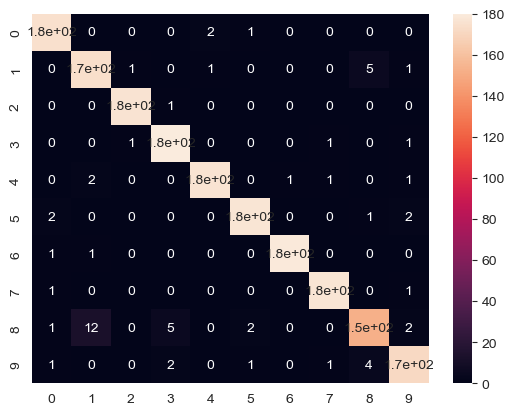

In [36]:
sns.heatmap(cm, annot=True)
plt.savefig('confmat.png')

print(classification_report(y_test, y_pred_labels))